# Data Cleanup

This notebook details some of the data preprocessing for the dynamic data.


In [1]:
import os

import pandas as pd
import numpy as np

In [2]:
def list_full_paths(directory):
    """Returns array of all file paths for every file in a directory"""
    return np.array(
        [
            os.path.join(directory, file)
            for file in os.listdir(directory)
            # Check if path is a file (we don't want directory paths)
            if os.path.isfile(os.path.join(directory, file))
        ]
    )


# List full paths of all files in the "Samples" directory
filepaths = list_full_paths("Samples")

In [3]:
# Step files have "StepActive" in their file
step_idx = np.array(["StepActive" in path for path in filepaths])
step_files = filepaths[step_idx]
trace_files = filepaths[~step_idx]  # Use arrays instead of lists for negation operator 😉

## Trace File Cleanup


In [4]:
# Read every dataframe in the list of  trace file paths
trace_dfs = [pd.read_csv(path) for path in trace_files]

# Concatenate our list of dataframes only if the columns are the same
df = None
if all([set(trace_dfs[0].columns) == set(df.columns) for df in trace_dfs]):
    df = pd.concat(trace_dfs)
    df.reset_index(inplace=True, drop=True)  # reset indices and drop the old ones
df

,Time,Id,Beta1,Beta2,ChiSquare1,Exponential1,InverseGamma1,Laplace2,Normal1
0,2022-11-03T12:42:34.367-06:00,2,0.721738,0.809026,4.276073,77.002384,2.447763,22.316681,35.723289
1,2022-11-03T12:42:34.475-06:00,2,0.707221,0.704481,2.674395,0.793823,3.943652,3.467332,53.271727
2,2022-11-03T12:42:34.567-06:00,2,0.616985,0.657483,0.682837,5.557007,4.737076,3.273708,56.451008
3,2022-11-03T12:42:34.676-06:00,2,0.627748,0.717226,0.565415,45.434308,6.354060,7.892505,43.809318
4,2022-11-03T12:42:34.768-06:00,2,0.724380,0.659851,4.073181,76.624741,3.571937,-2.768652,56.047099
...,...,...,...,...,...,...,...,...,...
99480,2022-11-03T12:42:33.874-06:00,2,0.599703,0.615747,1.656751,91.217196,18.533837,4.364182,58.199373
99481,2022-11-03T12:42:33.966-06:00,2,0.670499,0.598254,0.576961,24.487598,14.449341,4.138651,51.261836
99482,2022-11-03T12:42:34.074-06:00,2,0.708241,0.707972,0.934967,23.273163,3.707563,-1.989337,56.066612
99483,2022-11-03T12:42:34.167-06:00,2,0.556304,0.691143,1.176346,26.992628,3.011257,-0.921211,44.338716


In [5]:
# Create a dataframe for the variables of interest (third column through the end)
columns = df.columns[2:]
data_df = df[columns]
data_df

,Beta1,Beta2,ChiSquare1,Exponential1,InverseGamma1,Laplace2,Normal1
0,0.721738,0.809026,4.276073,77.002384,2.447763,22.316681,35.723289
1,0.707221,0.704481,2.674395,0.793823,3.943652,3.467332,53.271727
2,0.616985,0.657483,0.682837,5.557007,4.737076,3.273708,56.451008
3,0.627748,0.717226,0.565415,45.434308,6.354060,7.892505,43.809318
4,0.724380,0.659851,4.073181,76.624741,3.571937,-2.768652,56.047099
...,...,...,...,...,...,...,...
99480,0.599703,0.615747,1.656751,91.217196,18.533837,4.364182,58.199373
99481,0.670499,0.598254,0.576961,24.487598,14.449341,4.138651,51.261836
99482,0.708241,0.707972,0.934967,23.273163,3.707563,-1.989337,56.066612
99483,0.556304,0.691143,1.176346,26.992628,3.011257,-0.921211,44.338716


If you were to drop 0's, you wouldn't be able to use d3's `line.defined` to explicitly show which spots don't have measurements https://observablehq.com/@d3/d3-line#cell-329. Therefore, instead of dropping all rows that are 0-valued, we set these 0-valued rows to NaN-valued.


In [6]:
# Get the indices where all rows are equal to zero
zeros_idx = (data_df == 0).all(axis=1)
# At these locations, replace 0 values with NaNs (do in-place and ignore warning)
data_df.loc[zeros_idx] = data_df.loc[zeros_idx].replace(0, np.nan)
nan_data = pd.concat([df[df.columns[:2]], data_df], axis="columns")
# Parse dates as times, then sort the dataframe by time
nan_data.Time = nan_data.Time.apply(pd.to_datetime)
nan_data.sort_values("Time", inplace=True)

C:\Users\khanm\AppData\Local\Temp/ipykernel_26732/2694371116.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df.loc[zeros_idx] = data_df.loc[zeros_idx].replace(0, np.nan)


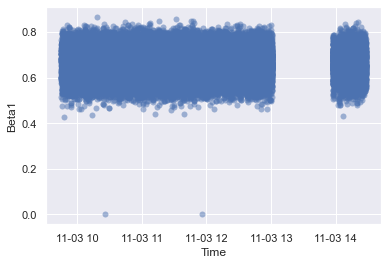

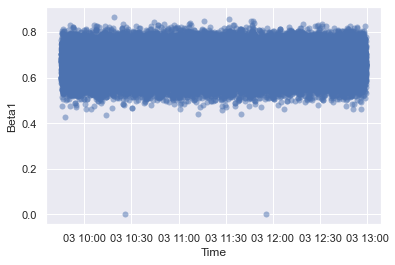

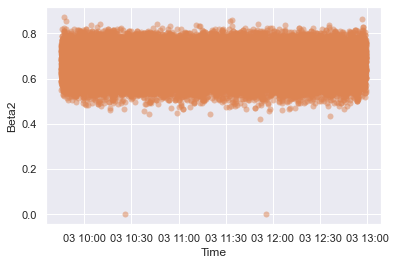

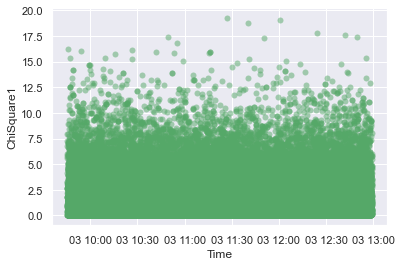

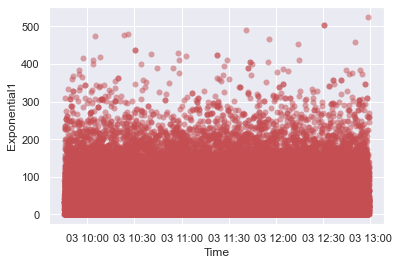

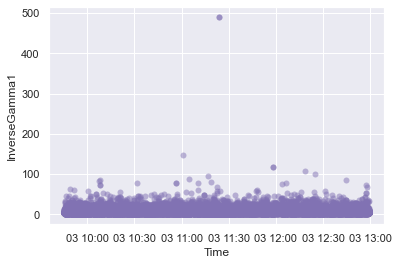

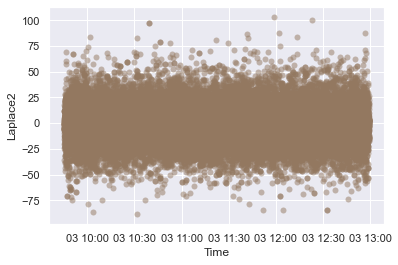

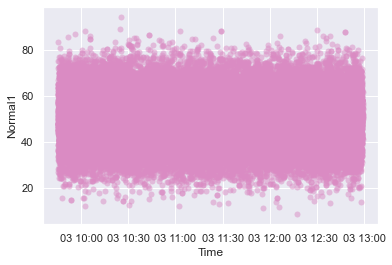

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme()
colors = sns.color_palette("deep", len(columns))

# First, plot just one trace to show that there's a big skip near the end
sns.scatterplot(
    data=nan_data, x="Time", y="Beta1", color=colors[0], linewidth=0, alpha=0.5,
)
plt.show()

# Then, plot every trace without the last 13,000 rows of nan_data
for count, column in enumerate(columns):
    sns.scatterplot(
        data=nan_data.iloc[:-13000],
        x="Time",
        y=column,
        color=colors[count],
        linewidth=0,
        alpha=0.5,
    )
    plt.show()

In [8]:
# The first few rows are also all NaN-valued;
# Select 27 through the last 13,000th to have values at beginning at end
data = nan_data.iloc[27:-13000].reset_index(drop=True)
data

,Time,Id,Beta1,Beta2,ChiSquare1,Exponential1,InverseGamma1,Laplace2,Normal1
0,2022-11-03 09:45:28.077000-06:00,2,0.639870,0.640328,0.218931,51.795686,7.814431,1.104654,35.852665
1,2022-11-03 09:45:28.169000-06:00,2,0.655279,0.655713,0.369592,92.319033,11.184301,-6.934259,53.023036
2,2022-11-03 09:45:28.262000-06:00,2,0.599226,0.642127,1.046868,39.826940,5.164356,-0.476925,36.260952
3,2022-11-03 09:45:28.371000-06:00,2,0.681321,0.622053,0.832904,28.965567,4.092354,-4.453715,45.227061
4,2022-11-03 09:45:28.463000-06:00,2,0.681321,0.622053,3.262792,0.887360,4.019753,-4.453715,51.253119
...,...,...,...,...,...,...,...,...,...
86453,2022-11-03 12:59:05.521000-06:00,2,0.643631,0.749690,0.167526,128.607925,7.184898,22.595490,57.027368
86454,2022-11-03 12:59:05.621000-06:00,2,0.667396,0.638925,3.597627,22.539380,6.687936,3.978629,50.850178
86455,2022-11-03 12:59:05.707000-06:00,2,0.667396,0.638925,3.597627,22.539380,6.687936,3.978629,50.850178
86456,2022-11-03 12:59:05.816000-06:00,2,0.636759,0.702124,0.533146,14.409088,15.775796,-2.472056,51.811510


In [9]:
# Show the total number of NaN's remaining of our 86,458 rows
print(data.isna().sum())
# Save the data
data.to_csv("traces_with_nans.csv", index=False)
data.to_json("traces_with_nans.json", orient="table", index=False)

Time                 0
Id                   0
Beta1            25483
Beta2            25483
ChiSquare1       25483
Exponential1     25483
InverseGamma1    25483
Laplace2         25483
Normal1          25483
dtype: int64


In [10]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
original_data = data[columns]
transformed_data = scaler.fit_transform(original_data)
transformed_data = pd.DataFrame(transformed_data, columns=columns)

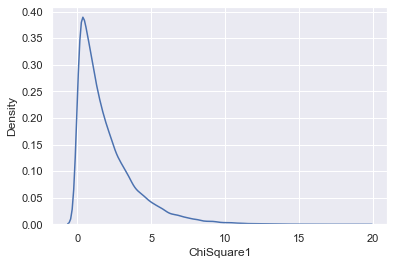

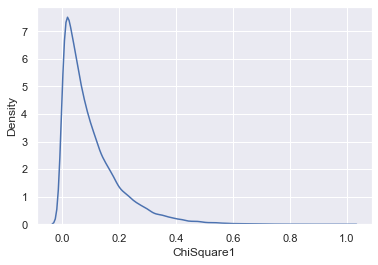

In [11]:
# Verify that distributions are unchanged
sns.kdeplot(data=data, x="ChiSquare1")
plt.show()
sns.kdeplot(data=transformed_data, x="ChiSquare1")
plt.show()

In [12]:
transformed_data.describe()

,Beta1,Beta2,ChiSquare1,Exponential1,InverseGamma1,Laplace2,Normal1
count,60975.000000,60975.000000,60975.000000,60975.000000,60975.000000,60975.000000,60975.000000
mean,0.768838,0.763285,0.103405,0.094913,0.013644,0.461375,0.484647
std,0.062469,0.062046,0.102756,0.095120,0.011185,0.072932,0.116614
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.727230,0.722292,0.030032,0.027207,0.007974,0.425921,0.405648
50%,0.770697,0.764932,0.071840,0.065870,0.011121,0.461466,0.484656
75%,0.812148,0.806174,0.144009,0.131858,0.016171,0.496828,0.563062
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [13]:
# Concatenate the Time and Id columns to transformed data, then save to file
scaled_data = pd.concat([data[["Time", "Id"]], transformed_data], axis="columns")
scaled_data.to_csv("scaled_traces.csv", index=False)
scaled_data.to_json("scaled_traces.json", orient="table", index=False)

## Event/Step File Cleanup


In [14]:
# Read every dataframe in the list of event file paths
event_dfs = [pd.read_csv(path) for path in step_files]

# Concatenate our list of dataframes only if the columns are the same
event_df = None
if all([set(event_dfs[0].columns) == set(df.columns) for df in event_dfs]):
    event_df = pd.concat(event_dfs)
    event_df.reset_index(inplace=True, drop=True)  # reset indices and drop the old ones
event_df

,Time,Id,StepCount
0,2022-11-03T14:25:03.043-06:00,ModuleProcess:5:GeneralExecution-StepActive,5
1,2022-11-03T14:25:04.137-06:00,ModuleProcess:5:GeneralExecution-StepActive,6
2,2022-11-03T14:25:05.262-06:00,ModuleProcess:5:GeneralExecution-StepActive,7
3,2022-11-03T14:25:06.386-06:00,ModuleProcess:5:GeneralExecution-StepActive,8
4,2022-11-03T14:25:07.495-06:00,ModuleProcess:5:GeneralExecution-StepActive,9
...,...,...,...
910,2022-11-03T14:24:54.426-06:00,ModuleProcess:5:GeneralExecution-StepActive,10
911,2022-11-03T14:24:58.705-06:00,ModuleProcess:5:GeneralExecution-StepActive,1
912,2022-11-03T14:24:59.764-06:00,ModuleProcess:5:GeneralExecution-StepActive,2
913,2022-11-03T14:25:00.822-06:00,ModuleProcess:5:GeneralExecution-StepActive,3


In [15]:
# Save to csv and json files
event_df.to_csv("events.csv", index=False)
event_df.to_json("events.json", orient="table", index=False)